<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter03/Steps_to_build_a_neural_network_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms 

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(2025)

In [2]:
data_folder = '../data/FMNIST' # This can be any directory you want to 

# 自定义transform函数
class ToTensorWithoutNormalization(object):
    """自定义变换：将图像转换为张量，但不进行归一化"""
    def __call__(self, pic):
        #  pic (PIL Image or numpy.ndarray): 图像数据。
        pic = np.array(pic).astype(np.float32)
        
        # 将NumPy数组转换为PyTorch张量
        tensor = torch.from_numpy(pic)
        
        # 如果图像是灰度图像（单通道），则添加通道维度
        tensor = tensor.unsqueeze(0)  # 添加通道维度，变为(C, H, W)
        
        return tensor

transform = transforms.Compose([
    # ToTensorWithoutNormalization(),
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x).astype(np.float32)).unsqueeze(0)),
    # transforms.ToTensor()   #这个函数会将数据归一化，不符合本程序要求
])

def get_data(): 
    train_dataset = datasets.FashionMNIST(root=data_folder, train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root=data_folder, train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_loader,test_loader


In [3]:
# tl,_=get_data()
# print(next(iter(tl)))

In [4]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [5]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [6]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
trn_dl,test_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for x,y in trn_dl:
        x=x.to(device)
        y=y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for x,y in test_dl:
        x=x.to(device)
        y=y.to(device)
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


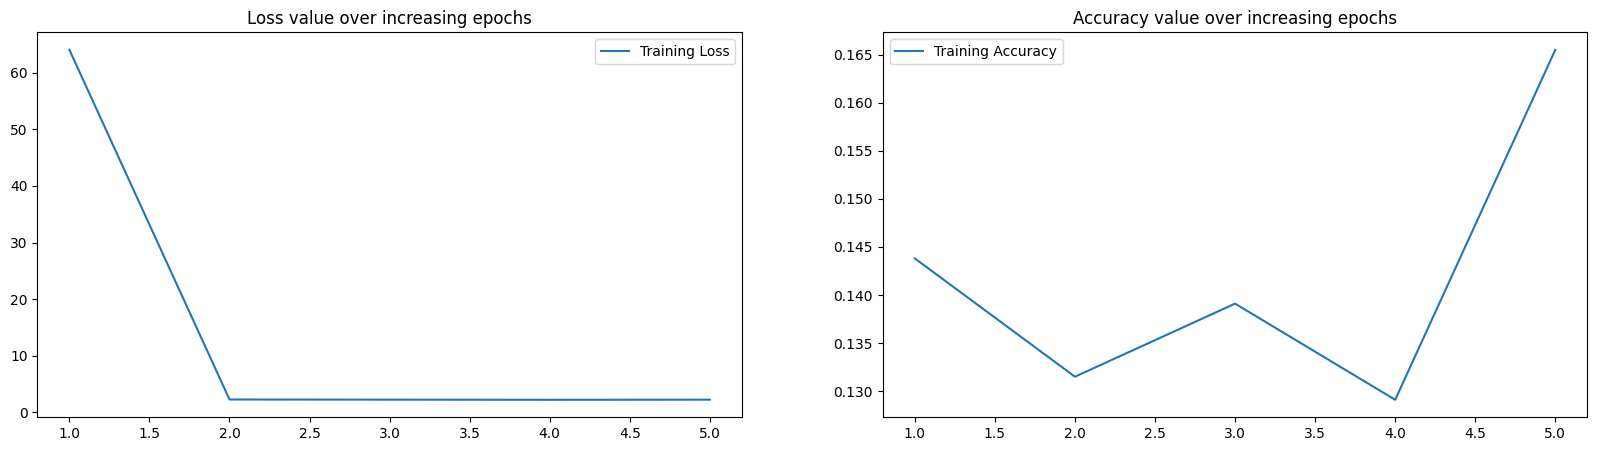

In [10]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()